In [18]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf


class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, frozen_path):
        self.graph = tf.Graph()
        graph_def = None
        with open(frozen_path, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')
        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image):
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map

    def returnSize(self,image):
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        return target_size


def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.

    Returns:
      A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
      label: A 2D array with integer type, storing the segmentation label.

    Returns:
      result: A 2D array with floating type. The element of the array
        is the color indexed by the corresponding element in the input label
        to the PASCAL color map.

    Raises:
      ValueError: If label is not of rank 2 or its value is larger than color
        map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
        FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


# label setting
LABEL_NAMES = np.asarray([
    'background', 'dog', 'cat', 'hourse'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)


def main():
    img_path = "frame1300.jpg"
    model_path = "./datasets/pascal_voc_seg/exp/train_on_trainval_set/train/export/frozen_inference_graph.pb"

    # load model
    model = DeepLabModel(model_path)

    # read image
    original_im = Image.open(img_path)

    # inferences DeepLab model
    resized_im, seg_map = model.run(original_im)

    # show inference result
    vis_segmentation(resized_im, seg_map)

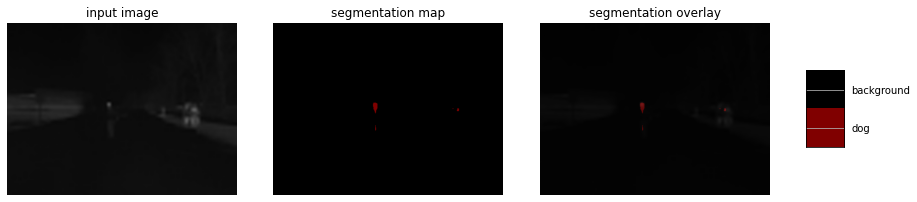

In [19]:
if __name__ == '__main__':
    main()